# Assignment 2 - Deep learning course - Handling Overfitting

Bar Dahan - 208010850

**Note:** In the first part of the notebook, I defined several different functions that will serve me in the following tasks.

In [7]:
# import required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from torch.utils.data import Subset
import torchvision.models as models

device = ("cuda"if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# #set hyperparameters




In [8]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 50
RANDOM_SEED = 42
TRAIN_SIZE = 0.8
REDUCE = 0.10

# #Define plot function

In [10]:
def plot_history(history, title="Training Results"):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='lower right')
    plt.grid(True)

    # --- Plot Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()


# # Defining train and validation functions

In [11]:
def train_loop(model, loader, loss_fn, optimizer):
    size = len(loader.dataset)
    num_batches = len(loader)
    model.train()

    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(loader):
        # Move to GPU
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics accumulation
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate average
    avg_loss = train_loss / num_batches
    accuracy = 100 * correct / size

    return avg_loss, accuracy

# Validation Function
def val_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)

            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate average
    avg_loss = val_loss / num_batches
    accuracy = 100 * correct / size

    return avg_loss, accuracy

# #Defining the CNN architecture


In [12]:
class cnn(nn.Module):
    def __init__(self, num_classes):
        super(cnn, self).__init__()

        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(64 * (IMAGE_SIZE//8) * (IMAGE_SIZE//8), 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)


# # Define experiment function

In [13]:
# Function to run a full experiment (Training + Validation over epochs)
def run_experiment(model, train_loader, val_loader, criterion, optimizer, epochs, description="Experiment"):

    print(f"Starting experiment: {description}...")

    # Dictionary to store results for plotting later
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # 1. Run the training step (using the train_loop function defined earlier)
        train_loss, train_acc = train_loop(model, train_loader, criterion, optimizer)

        # 2. Run the validation step (using the val_loop function defined earlier)
        val_loss, val_acc = val_loop(model, val_loader, criterion)

        # 3. Store the results in the history dictionary
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # 4. Print progress to the console
        print(f'Epoch {epoch+1:2d}/{epochs} | '
              f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:5.2f}% | '
              f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:5.2f}%')

    print(f"Finished: {description}\n")
    return history

# Part A - Loading & Reducing Dataset

note: the cell indludes baseline dataloaders sized 64*64 .

In [14]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #imagenet
])

# Load CIFAR-10
trainval_data_full = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

# Reduce dataset size
reduced_size = int(len(trainval_data_full) * REDUCE)
trainval_data, _ = random_split(trainval_data_full, [reduced_size, len(trainval_data_full) - reduced_size],
                                 generator=torch.Generator().manual_seed(RANDOM_SEED))

train_size = int(TRAIN_SIZE * len(trainval_data))
val_size = len(trainval_data) - train_size
train_data, val_data = random_split(trainval_data, [train_size, val_size],
                                    generator=torch.Generator().manual_seed(RANDOM_SEED))

print(f'Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}')
print(f'Classes: {len(trainval_data_full.classes)}')

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders Ready!")

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Train: 4000, Val: 1000, Test: 10000
Classes: 10
DataLoaders Ready!


# # Visualizing the dataset

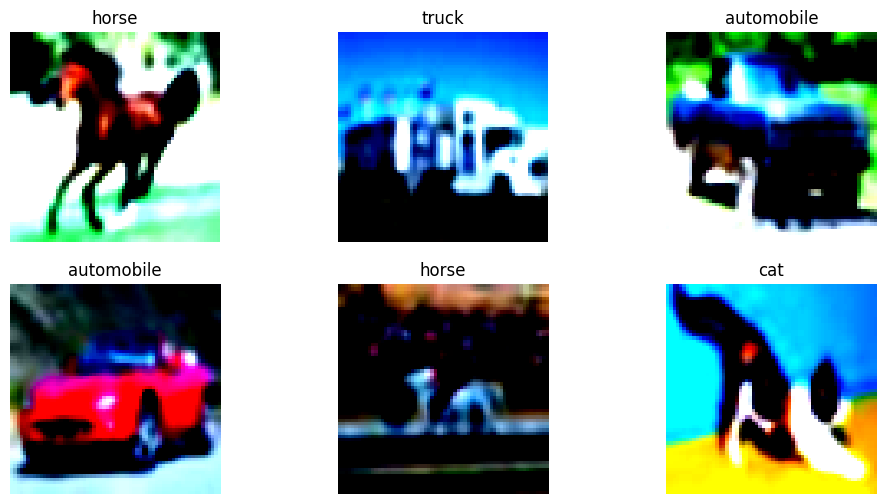

In [15]:
# Grab a single batch of images and labels from the dataloader
images, labels = next(iter(train_loader))

#Get the list of class names
class_names = trainval_data_full.classes

# Plot 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)

    # We need to change dimensions for plotting:
    # From PyTorch format (C, H, W) -> To Matplotlib format (H, W, C)
    img_to_show = images[i].permute(1, 2, 0)

    plt.imshow(img_to_show)

    label_index = labels[i].item()
    plt.title(class_names[label_index])
    plt.axis("off")

plt.show()

# #Basic Training to check overfitting

In [16]:
# Initialize CNN model
num_classes = len(trainval_data_full.classes)
print(f'Number of classes for CIFAR10 dataset: {num_classes}')
model = cnn(num_classes).to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Number of classes for CIFAR10 dataset: 10
Parameters: 2,126,378


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = run_experiment(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    description="Basic Experiment"
)

Starting experiment: Basic Experiment...
Epoch  1/50 | Train Loss: 2.205 | Train Acc: 18.65% | Val Loss: 2.041 | Val Acc: 29.80%
Epoch  2/50 | Train Loss: 1.917 | Train Acc: 31.98% | Val Loss: 1.842 | Val Acc: 34.90%
Epoch  3/50 | Train Loss: 1.762 | Train Acc: 38.38% | Val Loss: 1.785 | Val Acc: 35.40%
Epoch  4/50 | Train Loss: 1.649 | Train Acc: 42.27% | Val Loss: 1.671 | Val Acc: 41.80%
Epoch  5/50 | Train Loss: 1.567 | Train Acc: 45.88% | Val Loss: 1.638 | Val Acc: 42.70%
Epoch  6/50 | Train Loss: 1.481 | Train Acc: 48.52% | Val Loss: 1.593 | Val Acc: 44.20%
Epoch  7/50 | Train Loss: 1.419 | Train Acc: 51.35% | Val Loss: 1.567 | Val Acc: 44.90%
Epoch  8/50 | Train Loss: 1.379 | Train Acc: 52.90% | Val Loss: 1.545 | Val Acc: 44.90%
Epoch  9/50 | Train Loss: 1.320 | Train Acc: 55.08% | Val Loss: 1.521 | Val Acc: 47.80%
Epoch 10/50 | Train Loss: 1.278 | Train Acc: 55.15% | Val Loss: 1.516 | Val Acc: 48.20%
Epoch 11/50 | Train Loss: 1.247 | Train Acc: 56.75% | Val Loss: 1.557 | Val Acc

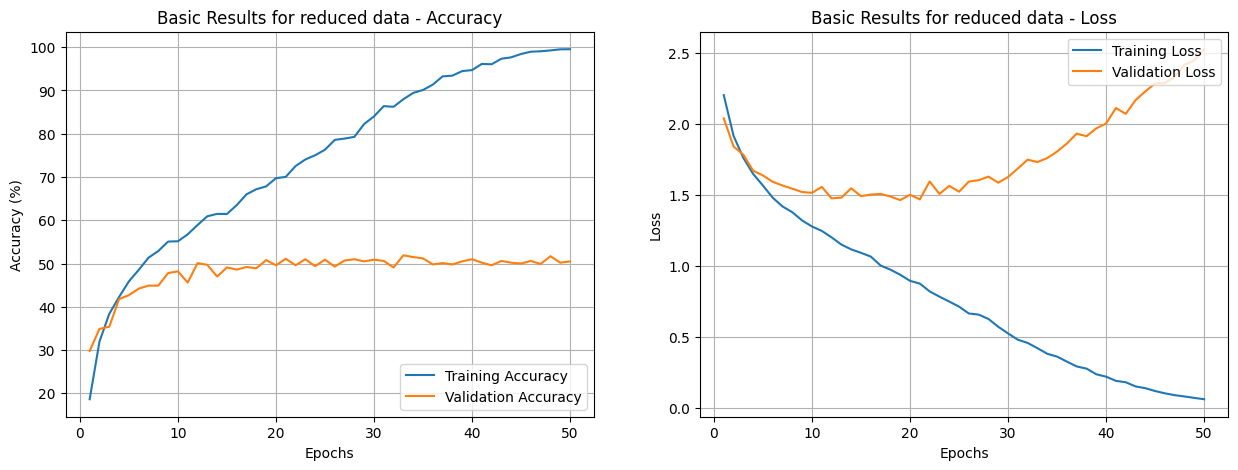

In [18]:
# Plot the results
plot_history(history, title="Basic Results for reduced data")

In [19]:
test_loss, test_acc = val_loop(model, test_loader, criterion)
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 50.73%


## Overfitting Results Analysis
The basic model demonstrates significant overfitting.
Training accuracy reaches 99% while validation accuracy remains around 50%. This lack of generalization is further confirmed by the test accuracy of 50.73%
This performance gap indicates the model has memorized the limited training data rather than learning generalizable patterns.


# Part B - Testing Overfitting Methods:
In this part We will test several techniques to reduce overfitting:
1. Data augmentation
2. Transfer learning
3. Regularization
4. Dropout

# **1. Data Augmentation**


# Transforms

In [20]:
# Define training data transforms with augmentation
train_transform_aug = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),   # Randomly flip images horizontally
    transforms.RandomRotation(15),            # Randomly rotate up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Randomly change colors
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation Transform: Clean (only resize and normalize) for fair evaluation
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined.")

Transforms defined.


# Load Data & Apply Split Logic


In [21]:
# Load dataset twice: one for training (augmented) and one for validation (clean)
full_train_dataset_aug = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform_aug)
full_val_dataset_clean = datasets.CIFAR10(root="data", train=True, download=True, transform=val_transform)

# Replicate the split indices from Part A
# We use the same RANDOM_SEED to guarantee the exact same data split
original_len = len(full_train_dataset_aug) # 50,000
reduced_len = int(original_len * REDUCE)   # 10% = 5,000

# Generate shuffled indices
g = torch.Generator().manual_seed(RANDOM_SEED)
indices = torch.randperm(original_len, generator=g).tolist()

# Select only the first 10%
subset_indices = indices[:reduced_len]

# Split into Train (80%) and Validation (20%)
train_size = int(TRAIN_SIZE * len(subset_indices)) # 4,000

train_indices = subset_indices[:train_size]      # Indices for training
val_indices = subset_indices[train_size:]        # Indices for validation

# Create the final Subsets
# Train subset uses the Augmented dataset
train_dataset = Subset(full_train_dataset_aug, train_indices)
# Validation subset uses the Clean dataset
val_dataset = Subset(full_val_dataset_clean, val_indices)

print("Datasets created successfully with consistent split.")

Datasets created successfully with consistent split.


# Create DataLoaders


In [22]:

train_loader_aug = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Augmented Train size: {len(train_dataset)} images")
print(f"Clean Val size:     {len(val_dataset)} images")

Augmented Train size: 4000 images
Clean Val size:     1000 images


# Visualize augmentations

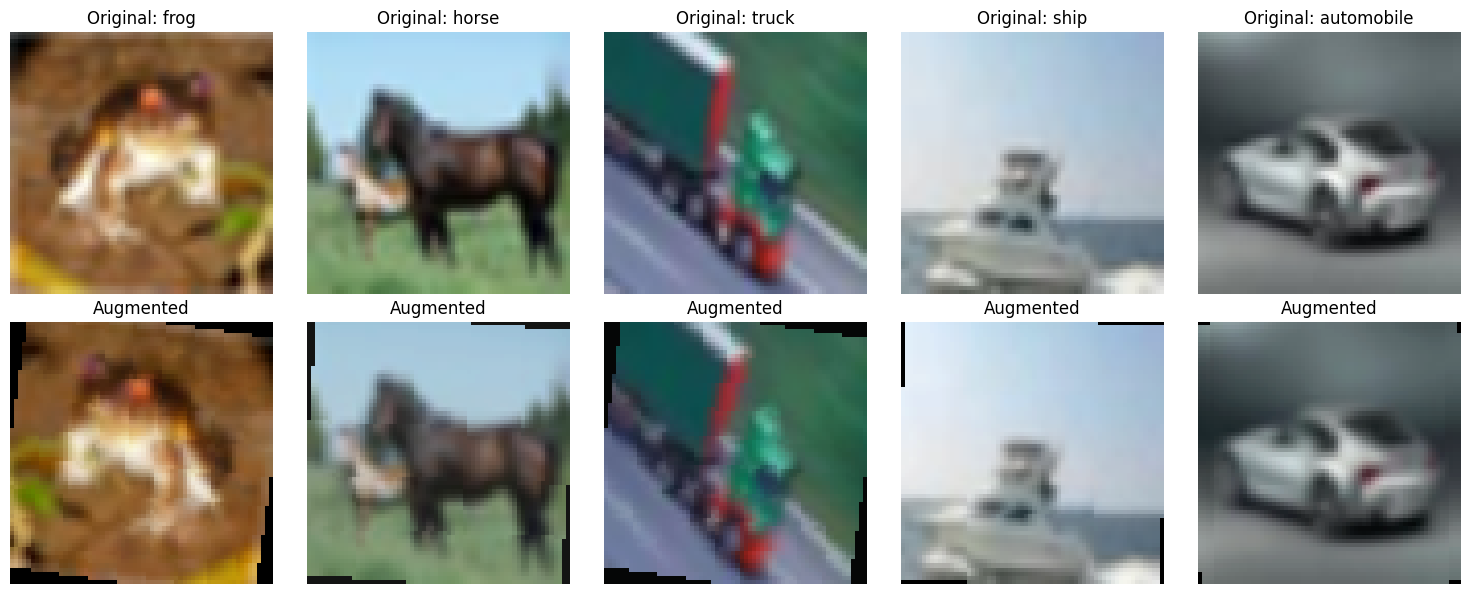

In [23]:
raw_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=None)

indices = [0, 12, 50, 100, 250]
num_images = len(indices)

def get_display_img(tensor_img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor_img.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices):
    orig_img, label = raw_dataset[idx]
    class_name = raw_dataset.classes[label]

    plt.subplot(2, num_images, i + 1)
    plt.imshow(orig_img.resize((IMAGE_SIZE, IMAGE_SIZE)))
    plt.title(f"Original: {class_name}")
    plt.axis('off')

    aug_tensor = train_transform_aug(orig_img)
    aug_display = get_display_img(aug_tensor)

    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(aug_display)
    plt.title(f"Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Training Loop & Results


In [24]:
# initialize new cnn nodel for  augmentation
model_aug = cnn(num_classes=10).to(device)

# Define Optimizer and Loss function
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

# Run the Augmentation Experiment
history_aug = run_experiment(
    model=model_aug,
    train_loader=train_loader_aug,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_aug,
    epochs=EPOCHS,
    description="Augmentation Experiment"
)

Starting experiment: Augmentation Experiment...
Epoch  1/50 | Train Loss: 2.184 | Train Acc: 20.90% | Val Loss: 2.046 | Val Acc: 27.90%
Epoch  2/50 | Train Loss: 1.935 | Train Acc: 31.20% | Val Loss: 1.856 | Val Acc: 35.40%
Epoch  3/50 | Train Loss: 1.788 | Train Acc: 37.05% | Val Loss: 1.787 | Val Acc: 37.70%
Epoch  4/50 | Train Loss: 1.695 | Train Acc: 40.35% | Val Loss: 1.717 | Val Acc: 42.20%
Epoch  5/50 | Train Loss: 1.637 | Train Acc: 41.95% | Val Loss: 1.687 | Val Acc: 41.00%
Epoch  6/50 | Train Loss: 1.586 | Train Acc: 43.40% | Val Loss: 1.668 | Val Acc: 41.40%
Epoch  7/50 | Train Loss: 1.545 | Train Acc: 45.65% | Val Loss: 1.610 | Val Acc: 43.60%
Epoch  8/50 | Train Loss: 1.505 | Train Acc: 46.10% | Val Loss: 1.592 | Val Acc: 43.80%
Epoch  9/50 | Train Loss: 1.475 | Train Acc: 47.83% | Val Loss: 1.578 | Val Acc: 45.60%
Epoch 10/50 | Train Loss: 1.435 | Train Acc: 48.88% | Val Loss: 1.586 | Val Acc: 44.90%
Epoch 11/50 | Train Loss: 1.427 | Train Acc: 50.02% | Val Loss: 1.585 | 

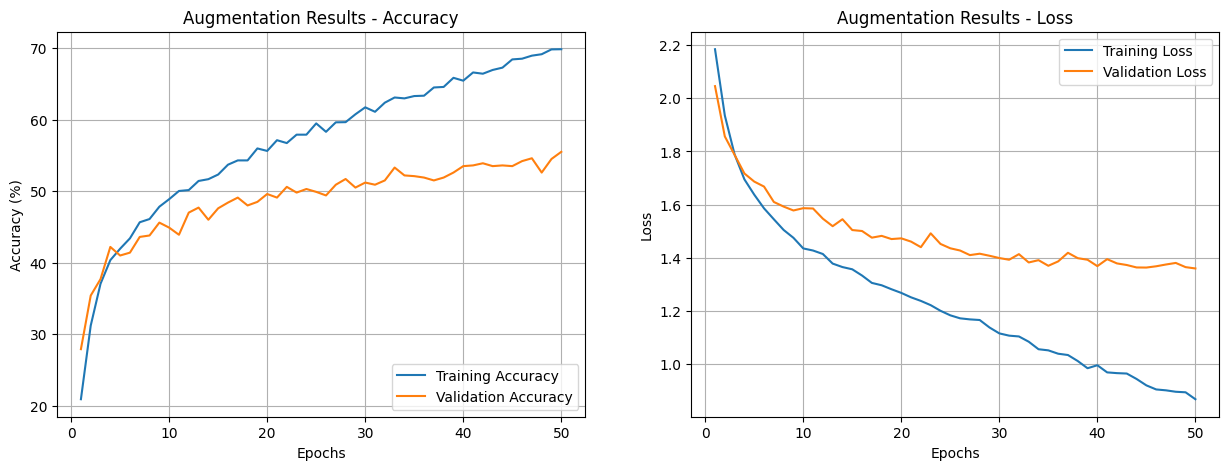

In [25]:
# Plot the results
plot_history(history_aug, title="Augmentation Results")

In [26]:
# Evaluate on Test Set
test_loss, test_acc = val_loop(model_aug, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}%')

Test Loss: 1.266 | Test Accuracy: 56.17%


## Augmentation Results Analysis

The augmented model demonstrates significantly reduced overfitting compared to the baseline. While the training accuracy decreased to approximately 69% (compared to the baseline's near-perfect score), the validation accuracy improved to 55%. This results in a much narrower performance gap of about 14%, indicating better generalization. The test accuracy of 56.17% confirms this improvement, showing that exposing the model to diverse variations of the training data helped it learn more robust features rather than simply memorizing specific examples.

# **2. Transfer Learning Setup**
Use pre-trained ResNet18 as a feature extractor for CIFAR-10.
Freeze all convolutional layers and only train the final classification layer (5,130 parameters out of 11.2M total).
Input images are resized to 224x224 to match ResNet's expected dimensions.


In [27]:
# Prepare Data for ResNet (Requires 224x224 images)
# Define the specific transform expected by ResNet (224x224 size)
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to the standard ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset again with the new transform
# We load the same dataset for both train and val, relying on indices to split them
resnet_data_raw = datasets.CIFAR10(root="data", train=True, download=True, transform=resnet_transform)
test_data_resnet = datasets.CIFAR10(root="data", train=False, download=True, transform=resnet_transform)
test_loader_resnet = DataLoader(test_data_resnet, batch_size=BATCH_SIZE, shuffle=False)
# Recreate the Exact Same Data Split
# We must use the same random seed and logic to ensure we train on the exact same images as previous tasks.

original_len = len(resnet_data_raw)       # 50,000
reduced_len = int(original_len * REDUCE)  # 10% -> 5,000

# Create the generator with the fixed seed
g = torch.Generator().manual_seed(RANDOM_SEED)
indices = torch.randperm(original_len, generator=g).tolist()

# Slice the indices
subset_indices = indices[:reduced_len]
train_size = int(TRAIN_SIZE * len(subset_indices))

train_indices = subset_indices[:train_size] # 80% for training
val_indices = subset_indices[train_size:]   # 20% for validation

# Create the Subsets
tl_train_dataset = Subset(resnet_data_raw, train_indices)
tl_val_dataset = Subset(resnet_data_raw, val_indices)

# Create new DataLoaders
tl_train_loader = DataLoader(tl_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
tl_val_loader = DataLoader(tl_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"ResNet Data Loaded: Train={len(tl_train_dataset)}, Val={len(tl_val_dataset)} (Size: 224x224)")

# Load and Setup the Pre-trained Model
# Load ResNet18 with the default pre-trained weights (trained on ImageNet)
weights = models.ResNet18_Weights.DEFAULT
resnet_model = models.resnet18(weights=weights)

# Freeze the feature extraction layers
# We iterate over all parameters and set requires_grad to False.
# This ensures the pre-trained weights remain unchanged during training.
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the Output Layer
# Get the number of inputs to the final Fully Connected (fc) layer
# For ResNet18, this is typically 512.
num_ftrs = resnet_model.fc.in_features

# Replace the existing 'fc' layer with a new one adapted to our specific task.
# CIFAR-10 has 10 classes. The new layer's weights are initialized randomly
# and have requires_grad=True by default.
resnet_model.fc = nn.Linear(num_ftrs, 10)



ResNet Data Loaded: Train=4000, Val=1000 (Size: 224x224)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [28]:
# Initialize model
resnet_model = resnet_model.to(device)

# Define Optimizer and Run Training
# We define the optimizer to update ONLY the parameters of the final layer (fc).
optimizer_tl = torch.optim.Adam(resnet_model.fc.parameters(), lr=LEARNING_RATE)

# Run the experiment
history_tl = run_experiment(
    model=resnet_model,
    train_loader=tl_train_loader,
    val_loader=tl_val_loader,
    criterion=criterion,
    optimizer=optimizer_tl,
    epochs=EPOCHS,
    description="Transfer Learning (ResNet18)"
)

Starting experiment: Transfer Learning (ResNet18)...
Epoch  1/50 | Train Loss: 2.285 | Train Acc: 15.28% | Val Loss: 2.157 | Val Acc: 22.60%
Epoch  2/50 | Train Loss: 2.059 | Train Acc: 27.65% | Val Loss: 1.962 | Val Acc: 36.50%
Epoch  3/50 | Train Loss: 1.869 | Train Acc: 39.83% | Val Loss: 1.792 | Val Acc: 46.30%
Epoch  4/50 | Train Loss: 1.714 | Train Acc: 51.00% | Val Loss: 1.656 | Val Acc: 52.60%
Epoch  5/50 | Train Loss: 1.578 | Train Acc: 57.42% | Val Loss: 1.536 | Val Acc: 58.40%
Epoch  6/50 | Train Loss: 1.473 | Train Acc: 60.88% | Val Loss: 1.437 | Val Acc: 62.20%
Epoch  7/50 | Train Loss: 1.379 | Train Acc: 64.40% | Val Loss: 1.355 | Val Acc: 64.70%
Epoch  8/50 | Train Loss: 1.301 | Train Acc: 66.50% | Val Loss: 1.287 | Val Acc: 67.40%
Epoch  9/50 | Train Loss: 1.230 | Train Acc: 69.03% | Val Loss: 1.226 | Val Acc: 68.70%
Epoch 10/50 | Train Loss: 1.174 | Train Acc: 70.85% | Val Loss: 1.176 | Val Acc: 68.30%
Epoch 11/50 | Train Loss: 1.134 | Train Acc: 71.35% | Val Loss: 1.1

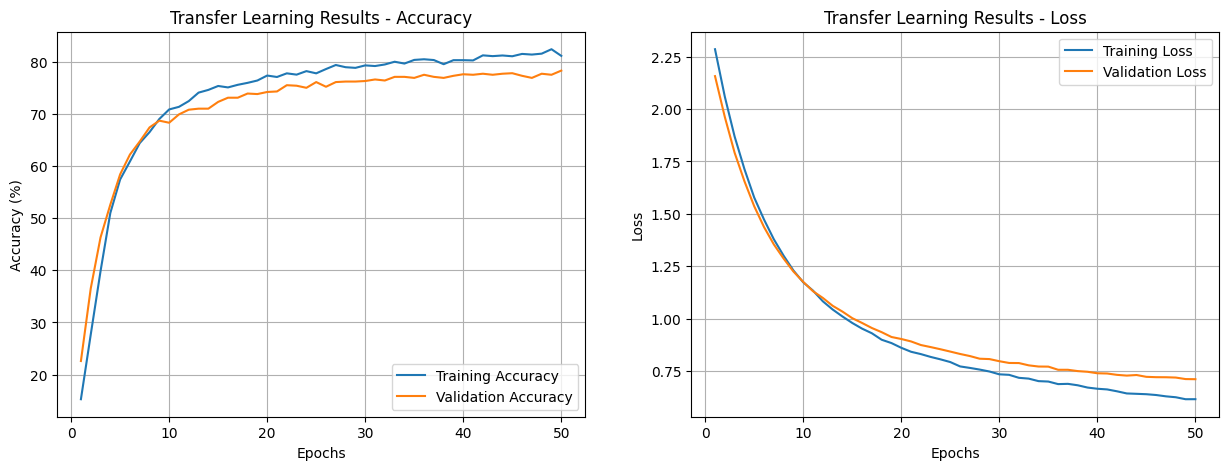

In [29]:
# Plot Results for Transfer Learning
plot_history(history_tl, title="Transfer Learning Results")

In [30]:
# Evaluate ResNet on Test Set
test_loss, test_acc = val_loop(resnet_model, test_loader_resnet, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.714 | Test Accuracy: 76.68%


## Transfer Learning Results Analysis
The Transfer Learning approach using ResNet18 demonstrated superior performance compared to both the baseline and augmentation methods. Training accuracy reached 81.12% while validation accuracy climbed to 78.30%, resulting in a minimal overfitting gap of less than 3%. The test set performance confirmed this strong generalization with an accuracy of 76.68%. This significant improvement (over 20% higher than the augmented model) highlights the effectiveness of leveraging pre-trained features from ImageNet, which allow the model to recognize complex patterns efficiently even with limited training data.

#**3. Regularization**

L2 Regularization Applied through weight_decay in the optimizer to penalize large weights


In [31]:
# Reset Data explicitly
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

reg_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)

# Re-create the split indices using the SAME seed
g = torch.Generator().manual_seed(RANDOM_SEED)
indices = torch.randperm(len(reg_dataset), generator=g).tolist()
subset_indices = indices[:int(len(reg_dataset) * REDUCE)] # 5000 indices

train_idx = subset_indices[:int(TRAIN_SIZE * len(subset_indices))] # 4000
val_idx = subset_indices[int(TRAIN_SIZE * len(subset_indices)):]   # 1000

# Create subsets for this experiment
reg_train_dataset = Subset(reg_dataset, train_idx)
reg_val_dataset = Subset(reg_dataset, val_idx)

# Create loaders
reg_train_loader = DataLoader(reg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
reg_val_loader = DataLoader(reg_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"loaded subset for L2: {len(reg_train_dataset)} training images.")

# Initialize model
model_L2 = cnn(num_classes=10).to(device)

#Define Optimizer with Weight Decay
optimizer_L2 = torch.optim.Adam(model_L2.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

# Run Experiment
history_L2 = run_experiment(
    model=model_L2,
    train_loader=reg_train_loader,
    val_loader=reg_val_loader,
    criterion=criterion,
    optimizer=optimizer_L2,
    epochs=EPOCHS,
    description="L2 Regularization (Weight Decay = 1e-3)"
)

loaded subset for L2: 4000 training images.
Starting experiment: L2 Regularization (Weight Decay = 1e-3)...
Epoch  1/50 | Train Loss: 2.156 | Train Acc: 21.77% | Val Loss: 2.000 | Val Acc: 29.40%
Epoch  2/50 | Train Loss: 1.880 | Train Acc: 33.77% | Val Loss: 1.882 | Val Acc: 36.40%
Epoch  3/50 | Train Loss: 1.744 | Train Acc: 40.20% | Val Loss: 1.830 | Val Acc: 35.00%
Epoch  4/50 | Train Loss: 1.636 | Train Acc: 43.20% | Val Loss: 1.718 | Val Acc: 40.40%
Epoch  5/50 | Train Loss: 1.543 | Train Acc: 46.15% | Val Loss: 1.673 | Val Acc: 42.90%
Epoch  6/50 | Train Loss: 1.465 | Train Acc: 48.98% | Val Loss: 1.665 | Val Acc: 40.70%
Epoch  7/50 | Train Loss: 1.419 | Train Acc: 49.95% | Val Loss: 1.602 | Val Acc: 43.70%
Epoch  8/50 | Train Loss: 1.369 | Train Acc: 51.80% | Val Loss: 1.554 | Val Acc: 45.10%
Epoch  9/50 | Train Loss: 1.317 | Train Acc: 53.50% | Val Loss: 1.555 | Val Acc: 45.50%
Epoch 10/50 | Train Loss: 1.280 | Train Acc: 54.42% | Val Loss: 1.541 | Val Acc: 45.00%
Epoch 11/50 

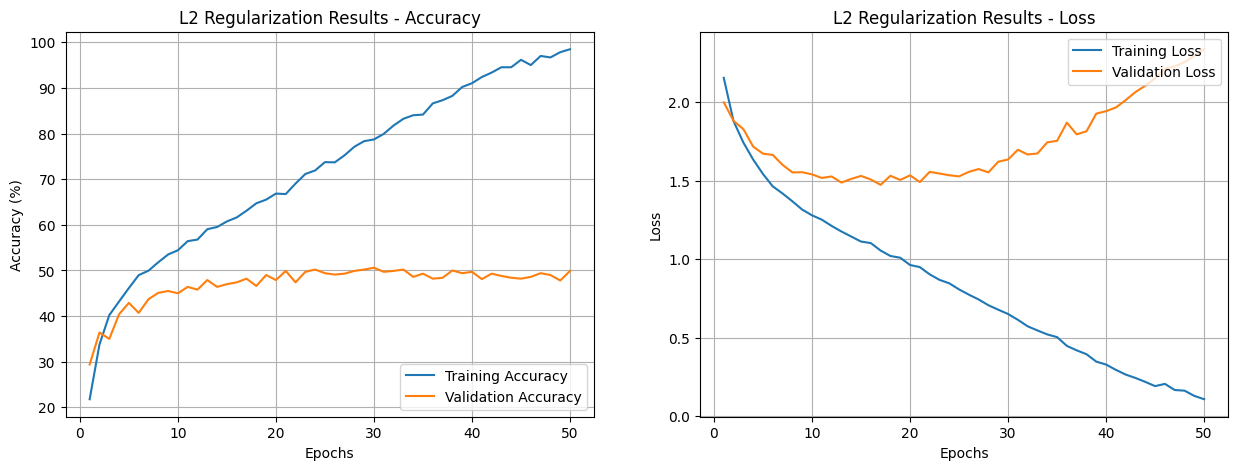

In [32]:
# Plot the results to visualize the effect of regularization
plot_history(history_L2, title="L2 Regularization Results")

In [33]:
# Evaluate on Test Set
test_loss, test_acc = val_loop(model_L2, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}%')

Test Loss: 2.129 | Test Accuracy: 51.43%


## Regularization Results Analysis
Despite using L2 Regularization, the model is still overfitting badly. The training accuracy went up to 98.5%, but the validation accuracy got stuck at 50%. The test result of 51.43% confirms that the model didn't really learn how to recognize new images.

Weight Decay tries to stop the model from becoming too complex, but it wasn't strong enough for this problem. Because our dataset is very small (only 4,000 images), the model was still able to memorize the training pictures instead of learning general rules. This shows that for small datasets, we usually need more than just L2 regularization to fix overfitting.

-------
# **4. Dropout**
Create a CNN with aggressive dropout to prevent overfitting.
Dropout layers are added after each pooling layer (Dropout2d with 50% rate) and after the first fully connected layer (Dropout with 50% rate).

During training, dropout randomly deactivates 50% of neurons, forcing the network to learn redundant representations and preventing co-adaptation of features.
This strong regularization should significantly reduce the gap between training and validation performance.

In [52]:
# Define CNN with Dropout
def CNN_Dropout(num_classes):
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.4),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.4),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.4),

        nn.Flatten(),
        nn.Linear(64 * (IMAGE_SIZE//8) * (IMAGE_SIZE//8), 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

In [53]:
# Initialize the Dropout Model
model_dropout = CNN_Dropout(num_classes=10).to(device)

# Define Optimizer
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=LEARNING_RATE)

# Run the Experiment
# Using the ORIGINAL loaders (train_loader, val_loader)
history_dropout = run_experiment(
    model=model_dropout,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_dropout,
    epochs=EPOCHS,
    description="Dropout Regularization (p=0.4)"
)

Starting experiment: Dropout Regularization (p=0.4)...
Epoch  1/50 | Train Loss: 2.290 | Train Acc: 11.57% | Val Loss: 2.254 | Val Acc: 21.20%
Epoch  2/50 | Train Loss: 2.207 | Train Acc: 18.62% | Val Loss: 2.113 | Val Acc: 27.20%
Epoch  3/50 | Train Loss: 2.120 | Train Acc: 23.73% | Val Loss: 2.018 | Val Acc: 30.90%
Epoch  4/50 | Train Loss: 2.074 | Train Acc: 25.73% | Val Loss: 1.975 | Val Acc: 33.40%
Epoch  5/50 | Train Loss: 2.005 | Train Acc: 28.60% | Val Loss: 1.915 | Val Acc: 37.20%
Epoch  6/50 | Train Loss: 1.984 | Train Acc: 29.88% | Val Loss: 1.890 | Val Acc: 37.40%
Epoch  7/50 | Train Loss: 1.942 | Train Acc: 31.50% | Val Loss: 1.838 | Val Acc: 38.50%
Epoch  8/50 | Train Loss: 1.911 | Train Acc: 32.20% | Val Loss: 1.811 | Val Acc: 38.50%
Epoch  9/50 | Train Loss: 1.869 | Train Acc: 34.35% | Val Loss: 1.780 | Val Acc: 39.20%
Epoch 10/50 | Train Loss: 1.850 | Train Acc: 34.90% | Val Loss: 1.747 | Val Acc: 42.00%
Epoch 11/50 | Train Loss: 1.854 | Train Acc: 35.05% | Val Loss: 1

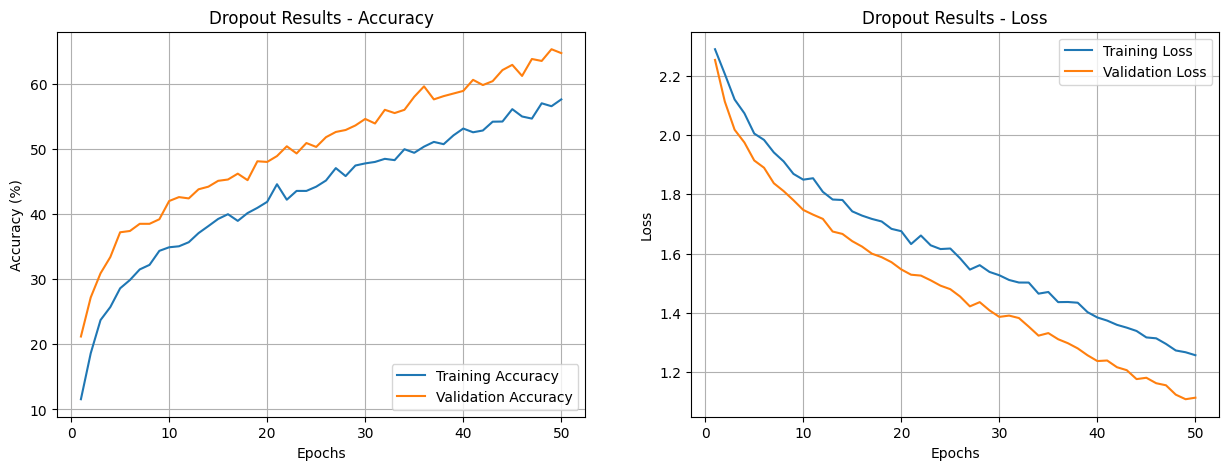

In [54]:
# Plot Results
plot_history(history_dropout, title="Dropout Results")

In [55]:
# Evaluate on Test Set
test_loss, test_acc = val_loop(model_dropout, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}%')

Test Loss: 1.490 | Test Accuracy: 47.71%


# # Confusion matrix & Classification Report (for CNN with Dropout)

Done collecting.


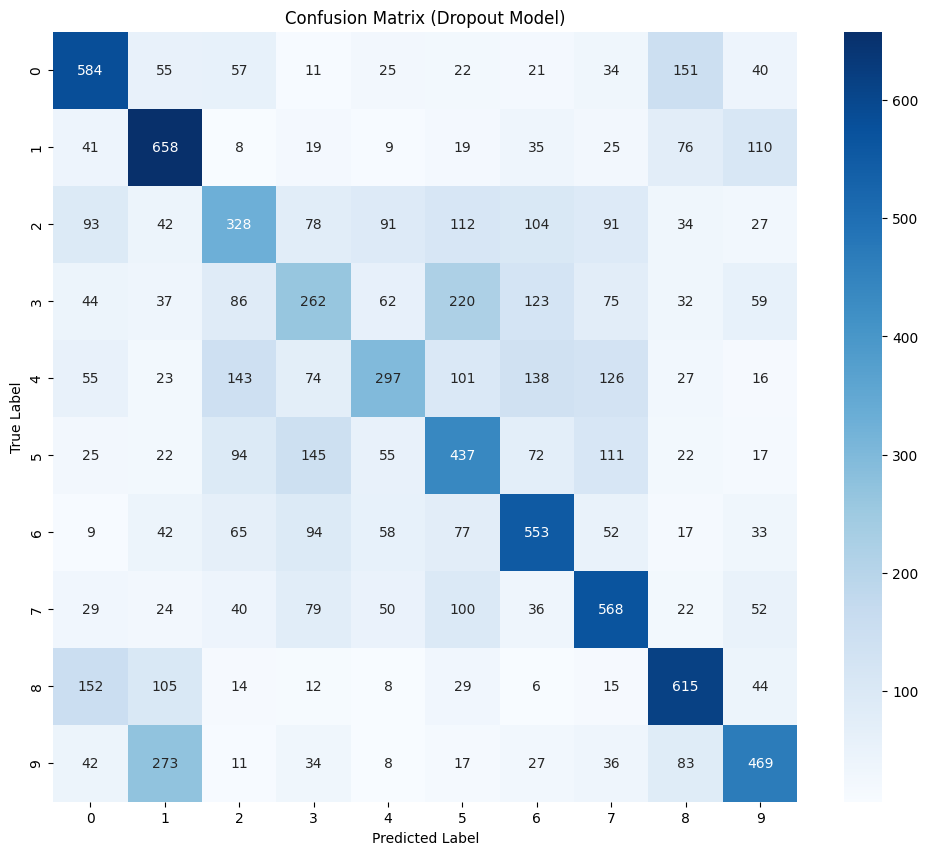


Classification Report:
              precision    recall  f1-score   support

    airplane       0.54      0.58      0.56      1000
  automobile       0.51      0.66      0.58      1000
        bird       0.39      0.33      0.36      1000
         cat       0.32      0.26      0.29      1000
        deer       0.45      0.30      0.36      1000
         dog       0.39      0.44      0.41      1000
        frog       0.50      0.55      0.52      1000
       horse       0.50      0.57      0.53      1000
        ship       0.57      0.61      0.59      1000
       truck       0.54      0.47      0.50      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_list = []
y_true_list = []

model_dropout.eval()

print("Collecting predictions...")


with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        outputs = model_dropout(X)

        _, preds = torch.max(outputs, 1)

        y_pred_list.extend(preds.cpu().numpy())
        y_true_list.extend(y.cpu().numpy())

print("Done collecting.")

cm = confusion_matrix(y_true_list, y_pred_list)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

plt.title('Confusion Matrix (Dropout Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

try:
    target_names = reg_val_loader.dataset.dataset.classes
except:
    target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("\nClassification Report:")
print(classification_report(y_true_list, y_pred_list, target_names=target_names, zero_division=0))

##Dropout Results Analysis ($p=0.4$)

Adjusting the Dropout rate to $p=0.4$ proved to be effective. It fixed the severe "underfitting" problem I saw when I tried $p=0.5$. The Training Accuracy improved to 57.60% (compared to only ~45% for p=0.5), indicating that the model regained the capacity to learn features while still being protected against overfitting.

A classic characteristic of Dropout is evident here: the Validation Accuracy (64.70%) is higher than the Training Accuracy. This happens because neurons are randomly deactivated during training (making learning harder), but are fully active during validation. However, there is a significant gap between the high Validation score and the real Test Accuracy (47.71%). This suggests that the Validation result was somewhat misleading due to the small size of the validation set (1,000 images). The Test Accuracy serves as the true metric, showing that while the model is stable, it is still constrained by the small training data. The Classification Report supports this: the model detects distinct shapes like Ships (F1 0.59) reasonably well but struggles with fine-grained classes like Cats (F1 0.29).

# Model Comparison & Conclusion

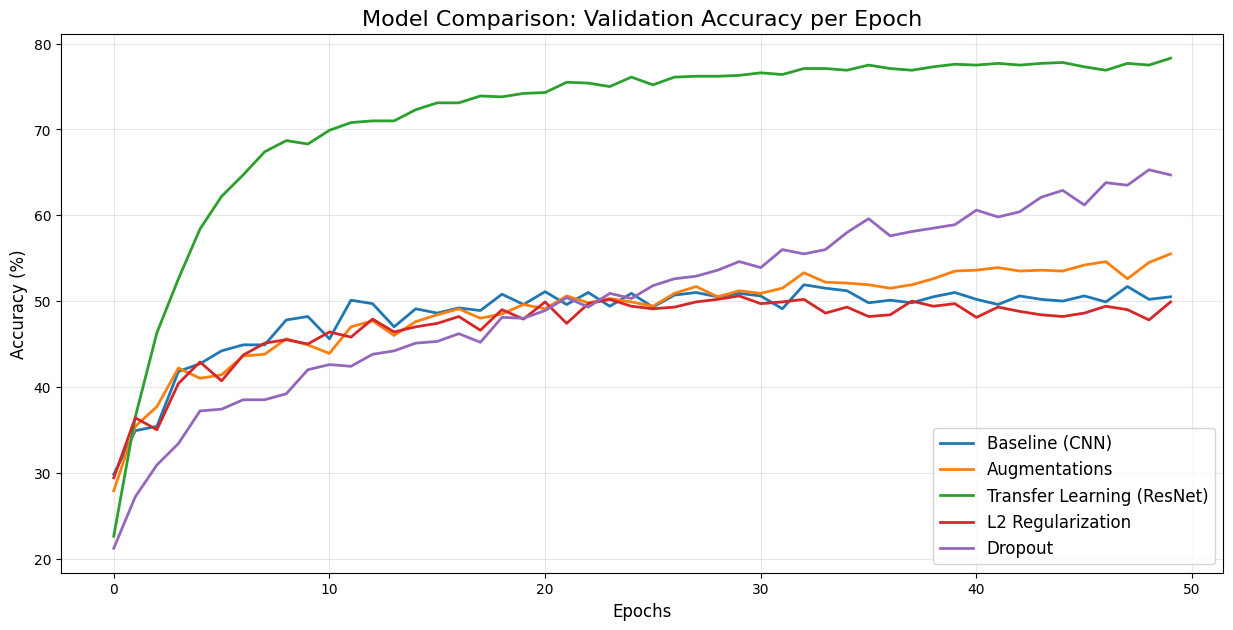


=== FINAL LEADERBOARD ===
Model Name                     | Max Val Accuracy
--------------------------------------------------
Baseline (CNN)                 | 51.90%
Augmentations                  | 55.50%
Transfer Learning (ResNet)     | 78.30%
L2 Regularization              | 50.60%
Dropout                        | 65.30%


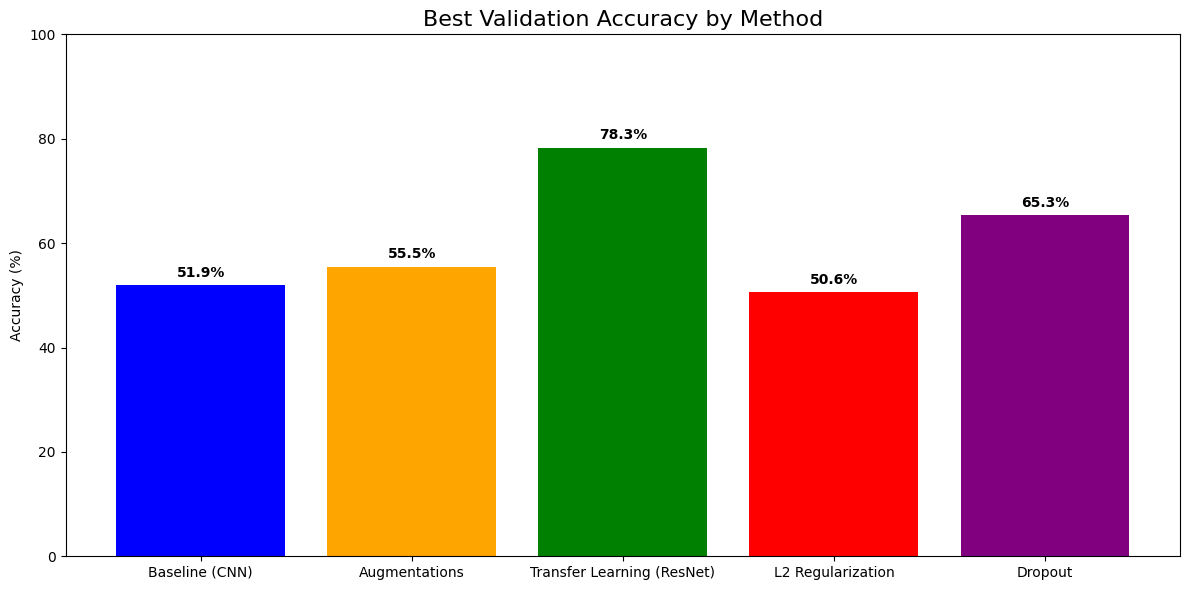

In [57]:
# We collect the history dictionaries from all previous experiments.
experiments = {
    'Baseline (CNN)': history,
    'Augmentations': history_aug,
    'Transfer Learning (ResNet)': history_tl,
    'L2 Regularization': history_L2,
    'Dropout': history_dropout
}

# Plot 1: Validation Accuracy Evolution
# This graph shows the learning curve. We can see which model learned the fastest
plt.figure(figsize=(15, 7))

for name, hist in experiments.items():
    val_acc = hist['val_acc']
    plt.plot(val_acc, label=name, linewidth=2) # Plot the validation accuracy curve for each model

plt.title('Model Comparison: Validation Accuracy per Epoch', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: Best Performance Leaderboard
# This graph shows the peak performance (highest accuracy) each model achieved.
plt.figure(figsize=(12, 6))

names = []
max_scores = []
colors = ['blue', 'orange', 'green', 'red', 'purple']

print("\n=== FINAL LEADERBOARD ===")
print(f"{'Model Name':<30} | {'Max Val Accuracy'}")
print("-" * 50)

for name, hist in experiments.items():
    # Find the highest validation accuracy achieved during training (best epoch)
    best_score = max(hist['val_acc'])

    names.append(name)
    max_scores.append(best_score)

    # Print the score to the console table
    print(f"{name:<30} | {best_score:.2f}%")

# Create the Bar Chart
bars = plt.bar(names, max_scores, color=colors[:len(names)])

plt.title('Best Validation Accuracy by Method', fontsize=16)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100) # Set y-axis scale from 0% to 100%

# Add numeric text labels on top of each bar for clarity
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

##Final Model Comparison & Conclusion

The comprehensive comparison presents a clear picture regarding the effectiveness of the different methods. The winner is Transfer Learning (ResNet) with a Validation Accuracy of 78.30%, significantly outperforming all other models. This result demonstrates that for problems with limited data (4,000 images), leveraging a pre-trained model is far superior to training a model from scratch. Among the models trained from scratch, the Dropout model (with $p=0.4$) achieved the best performance (65.30%), indicating its effective in preventing memorization. Data Augmentation provided a moderate improvement (55.50%) compared to the Baseline (51.90%), while L2 Regularization (50.60%) failed to improve performance and even resulted in slightly lower accuracy than the baseline. This reinforces the conclusion that weight penalty alone is insufficient to address the overfitting problem in this specific dataset.

**It is important to note** that while this study isolated each technique for comparative analysis, practical Deep Learning applications rarely rely on a single method. The optimal strategy lies in combining the strong feature extraction of Transfer Learning with the generalization capabilities of Data Augmentation and Dropout is the key to achieving superior, production-grade performance on limited datasets.